# Final project of Mobile Robotique 

Student group number 19 : <br/>
Kyan Achtari <br/>
Louis Gavignet <br/>
Louise Genoud <br/>
Joaquim Silveira <br/>

# 1) Introduction
<br/>
The project of Mobile Robotics aims to combine vision, path planning, global navigation, local navigation, and filtering with a kalman filter to move Thymio to the goal.
<br/><br/>
We first create a map composed of differents elements : black obstacles where the Thymio must never go, a blue triangle on Thymio to get his position and orientation in real time, a red square goal, and white small obstacles invisible to the camera.  The camera, using the vision modulus, gets the coordinates of every elements on the map from which we extracts a path. We then use the path planning with Dijkstra to extract the best suited path. 
<br/><br/>
While following the path, Thymio may encounter obstacles not detected by the camera. That's why it constantly scans the near environment with the IR sensors, when one is triggered Thymio avoids the obstacles using local navigation.
<br/><br/>
The robot also uses a filter to estimate the position with the help of sensors (camera and motor speed) and to correct it. We choose to implement the kalman filter, which shows a strong efficiency even when the camera is blocked.

# 2) Computer vision

### Hardware and Software Setup

For the computer vision implementation, we will be using the camera Aukey Stream Series 1080p Webcam. The OpenCV library will be used to process and treat the images to our convenience.

<img src="images/camera.jpg" alt="drawing" width="300"/>

### Object recognition

The first step is to differentiate three types of objects: obstacles, the robot and the goal area. They are respectively black, blue and red, can be either squares or triangles, and be placed almost anywhere inside the frame, so long as the obstacles are twice the robot's size apart. The object recognition process for either type consists of the same 4 steps : 

**1. Convert Image to HSV Color Space** : from research, we found out that the Hue Saturation Value color space is ideal for edge detection, as the distinction between the colors is more evident. Also, it is less sensible to the environment's lightning, as a full Value, equivalent to brightness, corresponds to how the color behaves and appears under a certain lightning. Therefore, full brightness does not mean the color will be white, but it's own color will be more radiant.

**2. Smooth the Image**: we smooth the image to reduce noise and make the pixel values inside an object more homogeneous, making it easer to establish an upper and lower color bound (in HSV of course). To smooth the image, we chose to employ the Bilateral Filter proposed by the OpenCV2 library. It is both effective for removing white noise and at the same time keeping edges sharp, which is what we'll need for the next step. Of course, it takes more computing power, but we can compensate this by reducing the image pixel width and height.

**3. Image Mask**: To create the object mask, we take the lower and upper color bounds for it, which were measured using the Gimp image processing software, and use the OpenCv2 InRange function, which basically applies a threshold to the image with the given bound. If the pixel is outside of the bound, it's value is set to 0, else it will be set to 1.

**4. Object Contour and Center Recognition**: Now with the object isolated in the image, we can detect it's contour and center with the OpenCv2 findContours function, which joins pixel with same values(which is why we apply thresholding, as it will work better to detect contours) and that are near by. Of course, it is highly likely that noise is still present up to this stage, which is why we apply an extra step: we approximate the contour with a simpler shape of roughly the same size, calculate it's area and reject it as a valid object if it is less than a certain threshold. This allows us to ignore smaller features that are big enough to not be picked up by the bilateral smoothing, that may be part of the arena texture. By calculating the moment of the approximated contour, we can find both it's area and center point. 

We now have all the informations we need for the objects: it's center, it's area and it's edge points. Each step result is shown by the following images:
| HSV image | Smooth Image | Image Mask | Object Contour|

<img src="images/obstacle/img_processed.png" alt="drawing" width="300"/> <img src="images/obstacle/img_hsv.png" alt="drawing" width="300"/>  <img src="images/obstacle/img_smooth.png" alt="drawing" width="300"/>  
<img src="images/obstacle/mask.png" alt="drawing" width="300"/>  <img src="images/obstacle/frame.png" alt="drawing" width="300"/>
    


### Robot Direction Detection
Unlike with the obstacles and the goal, we also care about the robot's direction, as we need to know its orientation to correctly move it through the world. For this, we use an isosceles triangle pointing forward. We calculate its edges and center as mentionned above, and can measure its forward orienting vector by finding which vertex of its contour is further away from the center point. This allows us to calculate its inclination, seen from above, with respect to the x axis, or the camera's horizon. The forward pointing vector is shown in the image below:

<img src="images/path.png" alt="drawing" height="350"/><img src="images/dir.png" alt="drawing" height="350"/>

This is done with the following function:
```
def get_robot_position(frame, robot_center, robot_contour):
    center = np.array(robot_center, dtype="object")
    contour = np.array(robot_contour, dtype="object")
    center = np.reshape(np.ravel(center), (-1,2))
    contour = np.reshape(np.ravel(contour), (-1,2)) 
    
    min_dist = 0
    max_index = 0
    dir_vector = alpha = 0
    for i in range(len(contour)):
        if euclidean(contour[i], center[0]) > min_dist:
            min_dist = euclidean(contour[i], center[0])
            max_index = i
    dir_vector = contour[max_index] - center[0]
    
    alpha = np.arctan2(dir_vector[1], dir_vector[0])
    cv2.arrowedLine(frame, center[0], contour[max_index], (0, 0, 255), 2)

    return dir_vector, alpha

```

### Computer Vision Step by Step

The following function is responsible for starting up the computer vision side of the project, detecting all the different object and providing the needed data for the Path Planning algorithm to execute properly:
```
def cv_start(video_capture, exposure = None, show_image = False, nb_tries = 5):
```
It does the following, in order:

1. **Setup the Camera** : starts the camera, ignores the first 300 frames, as the camera is still adjusting to the environment lightning, and sets it's exposure. This last parameter can be ignored, and the camera will set the exposure automatically. We choose to adjust it so it is easier to change our testing environment.
2. **Detect Obstacles, Robot and Goal Object** : We execute the object detection function to detect the three types of objects. We do this a few times, up until either all three types are detected or the maximum number of tries has been reached, so as to avoid infite loops.
3. **Robot Position and Orientation** : Finally, we get the robot position and orientation.

It returns the following data:

 - *cv_successful* : True if all types of objects were detected, false if either the latter is not true or the maximum number of tries has been reached
 - *obst_contours* : (x,y) position of obstacle vertices. Useful for the Path Planning algorithm.
 - *robot_pos* : (x,y) position of the center of the robot.
 - *goal_center* :  (x,y) position of the goal area.
 - *frame* : frame treated, with the drawn contours around each object.

# 3) Path planning

The vision module returns a list of obstacles, characterized by the coordinates of their vertices. From these points, the path planning module does several things :

- **Obstacle augmentation** : construct a series of points through which the Thymio can go, from the coordinates of the obstacle vertices
- **Graph construction** : build a graph structure with the right connections between vertices (so that Thymio cannot cross an obstacle) and the weights of the edges initialized (they correspond to th distances between the points)
- **Shortest path** : using Dijkstra's algorithm, find the shortest path from the start point to the end point, passing through a subset of the vertices

### Obstacle augmentation
The obstacle augmentation is done by moving each vertex of each obstacle in two different ways, as illustrated in the figure below for vertex A :  

<img src=images/obstacle.JPG width="400">

The point is moved in the direction parallel to each edge of the obstacle, and then in the perpendicular direction away from the obstacle. The distance of each of these translation is a constant defined as half the Thymio width plus a safety margin. This is done so that the robot will not collide with the corner of the obstacle when going around it.

### Graph construction
The construction of the graph from the augmented vertices is done in 2 steps for each obstacle :
- The consecutive vertices are connected to each other (yellow edges)
- The vertex of the obstacle that is the closest to a vertex of another obstacle is connected to that vertex (red edge)

<img src=images/path_around_sev.JPG width="800">  

The start point (given by the robot's initial position) and end point (target) are each connected to the vertex of the graph that is the closest to them.

### Shortest path
The shortest path can be computed using Dijkstra's algorithm on the graph that was constructed. First, the table of _distances_ is initialized with all distances to a value INF representing infinity, and the table of _predecessors_ is created. An _unconnected_ list is also created containing the indexes of all the vertices at the beginning.  

The _graph_ is a list of lists, with every vertex represented by a list of its connected vertices and the weight of the edge connecting them. 
These tables are then updated as such :

```
    while(len(unconnected)!=0):
    dp = distances.copy()[unconnected]
    idx_a = np.argmin(dp,axis=0)[0]
    a = int(dp[idx_a,1])
    remove(a,unconnected)

    for v_b in graph[a]:
        b = v_b[0]

        w_ab = get_weight(a,b,graph)
        if((w_ab > 0) and (distances[b,0]> distances[a,0] + w_ab)):
            distances[b,0] = distances[a,0] + w_ab
            predecessor[b] = a


return distances,predecessor
```

From the resulting list of predecessors, the path (_coord_) can then be extracted by walking through it from end to beginning:

```
coord.append(end)

while(pred[i] != len(pred)-2):
    i = pred[i]
    path_num.append(i)
    coord.append(coordlist[i][0:2])

coord.append(start)
coord.reverse()
```

# 4) Motion control

### Global navigation

##### Implementation of the movement
We create a fonction called pathing() that uses all the functions needed for moving the Thymio. In every iteration, pathing calls the camera, kalman, and refers to the path given by the path planning. The Thymio moves continuously and actuates the speed of his motors thanks to a proportionnal controller.

##### Rotation 
When the Thymio arrives at an intermediate goal, he has to change his orientation to go to the next one. The function get_angle_between() gives the angular difference between the two vectors

```
def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))
```

Then, we make sure the angle belongs to the interval [-$\pi$, $\pi$] :

```
def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle
```

##### Controller

We use a proportionnal controller to set the speed of the motors. It takes into account the angle for the correction or the new orientation. We also set an angle minimum under which the robot won't turn, the kalman correction can be very precice so we don't take it in consideration every time. This angle minimum is equal to 0.4 radians, which corresponds to 23 degrees. 

```
def controller(angle)
    if abs(angle) > ANGLE_TOLERANCE:
                speed_l = 80 - kp_rot*(angle)
                speed_r = 80 + kp_rot*(angle)
            else:
                speed_l = SPEED_AVG
                speed_r = SPEED_AVG
    return speed_l, speed_r
```

### Local navigation

We read the 7 horizontal sensor values and store them in prox.vals and multiply them by IR.SCALE.DOWN (which is 0.05), if any of the values is non-zero (other than the last 2, which are behind the Thymio), we enter obstacle avoidance:

Then we multiply the vector prox.vals by LEFT.IR.WEIGHT and RIGHT.IR.WEIGHT for each wheel:

$$
LEFT.IR.WEIGHT =
\left(\begin{array}{cc} 
1 \\
2 \\
-5 \\
-2 \\
-1 \\
0 \\
0 \\
\end{array}\right)
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
RIGHT.IR.WEIGHT =
\left(\begin{array}{cc} 
-1 \\
-2 \\
-5 \\
2 \\
1 \\
0 \\
0 \\
\end{array}\right)
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
$$

The speed of each wheel is their respective weight multiplied by the sensor values, and + 10

```
if sum(prox_vals[0], prox_vals[1], prox_vals[2], prox_vals[3], prox_vals[4]) > 0:
    obst = True

if obst == True:
    speed_l = sum(prox_vals * LEFT_IR_WEIGHT)  + 10
    speed_r = sum(prox_vals * RIGHT_IR_WEIGHT) + 10
```

# 5) Kalman filter 

### Overview and prediction

To calculate the beliefs of the robot position we setup a Bayes filter. It's a recursive filter that first calcultes a prediction of the robot positioon and then update the measurement. We implemented an extended Kalman filter because we conside a nonlinear gaussian state space model, as our physical model includes cosinusoidales factors. Our states are $X = (x,y, \theta)$. The states are modified by the speed of the left and right motors $U = (speed.left, spped.right)$. The nonlinear modification of each paramters can be modeled as follows : 

$$ x_{t+1} = x_{t} + v_{average}\cdot dt\cdot cos(\theta) $$ 
$$ y_{t+1} = y_{t} + v_{average} \cdot dt\cdot sin(\theta) $$ 
$$ \theta_{t+1} = \theta_{t} + dt\cdot \omega $$  

<c/><c/>
We can write the systeme above with the following matrices :
$$ X_{t+1} = A\cdot X_{t} + B\cdot U $$

<c/><c/>
With the following matrices A and B :
$$
A = 
\left(\begin{array}{cc} 
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
\end{array}\right)
$$

$$
B = 
\left(\begin{array}{cc} 
0.5\cdot dt\cdot cos(\theta) & 0.5 \cdot dt\cdot cos(\theta)\\
0.5\cdot dt \cdot sin(\theta) & 0.5\cdot dt\cdot sin(\theta) \\
-dt/wheeldist & dt/wheeeldist \\
\end{array}\right)
$$


The state transition covariance matrix Q, contains the variance of the motors speed :

$$ 
Q = 
\left(\begin{array}{cc}
speedvar & 0\\
0 & speedvar\\
\end{array}\right)
$$

<br/>
The covariance of the obervation noise matrix R, errors come from the camera when measuring a known object :

$$ 
R = 
\left(\begin{array}{cc}
camvar & 0 & 0\\
0 & camvar & 0\\
0 & 0 & camanglevar\\
\end{array}\right)
$$

It is a diagonal matrix as the $x$ position, $y$ position and $theta$ angle are independant variables. 

### Prediction

We can predict the next position of the robot thanks to the set of equations of the nonlinear $X_{t+1}$. We calculate the prediction at every time interval $dt$, this periode corresponds to reaction and update time of our robot. At each $dt$ we calculate the new orientation to follow the path, we update the speed of the motors, and we check with the Kalman filter that the Thymio is on the right path.

We also compute the prediction of an estimate of the covariance with the following expression:
$P = P+B\cdot Q\cdot B^T$
The Prediction code is the following:
```
def kalman_predict(previous_time, x, u, P):  
        start_time = time.time()
            
        if (previous_time != 0):
            dt = round(start_time - previous_time, 8)
        else:  
            dt = 0.2
        
        states_dim = len(x)     # x, y, theta
        control_dim = len(u)
        
        A = np.eye(states_dim)
        B = np.array([[0.5 * dt * np.cos(x[2]),     0.5 * dt * np.cos(x[2])], 
                      [0.5 * dt * np.sin(x[2]),     0.5 * dt * np.sin(x[2])],
                      [ -dt / ROBOT_LENGTH,          dt / ROBOT_LENGTH]], dtype='float')
 
        x = B.dot(u) + A.dot(x) 
        Q = SPEED_VAR * np.eye(control_dim)
        P = B.dot(Q).dot(B.T) + P

        return start_time, x, P
```

### Update 

Once we get a measurement of the states, with the camera in our case, we update the Kalman filter state estimation with the previously calculated Kalman Gain $K$, the measurement of the actual state ¨$z$ and the predicted state $x$. Then we update the values of the $P$ matrix with the following expressions:

$$I = z-X$$
and $$K = P \cdot H^T\cdot S$$  with $$S=R+H\cdot P^T\cdot H$$
then $$X=X+K\cdot I$$
and $$P = P-K\cdot H\cdot P$$ 

The Update code is the following: 
```
def kalman_update(x, z, P, sensor_available):
    R = np.diag([CAMERA_VAR, CAMERA_VAR, CAMERA_ANGLE_VAR])
    states_dim = len(x) 
    
    if sensor_available : H = np.eye(states_dim)
    else : H = np.zeros((states_dim, states_dim))

    I = z - x
    S = H.dot(P).dot(H.T)  + R
    K_gain = P.dot(H.T).dot(np.linalg.inv(S)) 
    x = x + K_gain.dot(I)
    P = P - K_gain.dot(H).dot(P)

    return x, P  
```

### Filter

The whole filtering processes, when the camera detects the robot, involves both Prediction and Update steps. However, on the abscence of measurements, we soly rely on the Prediction, as we have no measurements to update our beliefs. Kalman is implemented with the following function:

```

def kalman_filter(sensor_data_available, x, u, z, P , previous_time):

    next_time, x_kal, P  = kalman_predict(previous_time, x, u, P)
    x_predicted = x_kal
    if sensor_data_available == True :
        x_kal, P = kalman_update(x, z, P, sensor_data_available)

    return next_time, x_kal, P, x_predicted

```

### Calibration
In total, we need to calibrate the following parameters:
- *speedvar* : variance of the motor's speed. We use the values determined in Exercice 8 to determine it experimentally. The Covariance matrix $Q$ will be diagonal as the left and right speed are independant.
- *camvar* : position measurement noise of the camera. We again assume quite fairly that $x$ and $y$ noise are independant. For simplicity, we'll stretch this assumption to include $theta$ into the mix of independance. We measured the position of the robot and it's orientation, and most of the time, the position was inside a 2.5 pixel radius, which gives us a 0.05 variance.
- *camvarangle* : the orientation noise is given by the (x,y) position noise propagation in both axis, so it gives us $0.0025$.

This results where tested, with the following results:

<img src=images/kalman/tresbonkalman.png width="700">  

The filter worked as expected, joining the camera measurement once the robot was detectable again by the camera quite precisely. Other cases are shown below:

<img src=images/kalman/kalman.png width="700">  
<img src=images/kalman/kalman_good.png width="700">  



# 6) Overview and  Project Demonstration

### Overview
The robot's behaviour is depicted by the following general FSM: 

<img src=images/FSM.jpg width="700">  



### Step 1 : Includes and Functions Definition

In [1]:
%matplotlib inline
import numpy as np
import math
import time

from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import *

import tdmclient.notebook
await tdmclient.notebook.start()
# parametres
stop = 0
MIN_DIST = 35
MIN_OBST_DIST = 1000
ANGLE_TOLERANCE = 0.40
SPEED_AVG = 100
ROBOT_SPEED_TO_MM = 160/500
IR_SCALE_DOWN = 0.05

LEFT_IR_WEIGHT = [1,2,5,-2,-1,0,0]
RIGHT_IR_WEIGHT = [-1,-2,-5,2,1,0,0]

period = 0.15
nb_samples = int(3/period)
prox_int = np.zeros((1,nb_samples))
state = 'tracking'
timer = 0


@tdmclient.notebook.sync_var
def prox():
    global prox_horizontal
    # get the prox values   
    prox_vals = np.array(prox_horizontal) * IR_SCALE_DOWN
    return prox_vals

@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist

def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle

def controller(angle):
    kp_rot = 100
    kp_lin = 3
    obst = False

    prox_vals = prox()
    if sum(prox_vals) > 0:
        obst = True
    if obst == True:
        speed_l = sum(prox_vals * LEFT_IR_WEIGHT)  + 10
        speed_r = sum(prox_vals * RIGHT_IR_WEIGHT) + 10
    else:
        if abs(angle) > ANGLE_TOLERANCE:
            speed_l = 80 - kp_rot*(angle)
            speed_r = 80 + kp_rot*(angle)
        else:
            speed_l = SPEED_AVG
            speed_r = SPEED_AVG
    return int(speed_l), int(speed_r)

def pathing (video_capture, path, x0, y0, theta0):
    global period
    cam_hist = []
    kal_hist = []
    pred_hist = []

    teta = np.zeros(np.shape(path)[0])
    theta = 0
    speed_l = speed_r = 0
    goalx = path[1][0]
    goaly = path[1][1]
    theta_measure = 0
    i = 1
    curr_time = 0
    kx = kteta = ky = angle = 0
    robot_detected = False
    camera_available = False
    dist = distance (goalx, goaly, kx, ky)
    
    # kalman variables 
    P = 1000*np.eye(3)
    x = x_predicted = np.array([[x0],[y0],[theta0]])
    z = np.array([[0],[0],[0]])
    u = np.array([[0],[0]])
    previous_time = 0
    video_frames = []
    
    previous_time, x, P, x_predicted = kalman_filter(True, x, u, z, P , previous_time)

    while True:       
        #   step 1: get the image, detect the robot, and get the position
        current_time = time.time()
        camera_available, frame = video_capture.read()
        position_measure = []
        if camera_available == True:
            position_measure, position_contour, proccessed_framed, _, _,_ = computer_vision(frame, 'robot', True)
            # cv has detected the robot, we can use the position
            if len(position_measure) == 1:
                robot_detected = True
                position_measure = position_measure[0]

                if position_measure is not None:                    
                    _, theta_measure = get_robot_position(frame, position_measure, position_contour)
                    theta_measure = round(-theta_measure, 4)
                    position_measure = invert_coordinates(position_measure)
                    position_measure = pixel_to_metric(position_measure)
                    [kx, ky, kteta] = [position_measure[0], position_measure[1], theta_measure]
                    measurement = np.array([kx, ky, kteta])
                else:
                    robot_detected = False
            else:
            # robot not detected, we use kalman
                robot_detected = False
        vals = prox()
        
        
        if camera_available == False or robot_detected == False:
            measurement = np.array([0,0,0])         
        
        z = np.array([[measurement[0]], [measurement[1]], [measurement[2]]])
        previous_time, x, P, x_predicted = kalman_filter(robot_detected, x, u, z, P , previous_time)
        [pred_x, pred_y, pred_teta] = x
        
        
        dist = distance (goalx, goaly, pred_x, pred_y)
        theta = math.atan2((goaly - pred_y), (goalx - pred_x)) 
    

        if (dist < MIN_DIST):
            if i < np.shape(path)[0] - 1 :
                i = i + 1
                goalx = path[i][0]
                goaly = path[i][1]
            else:
                motors(stop, stop)
                break
        else :
            angle =  wrap_angle((theta - pred_teta) % (2*np.pi))

            speed_l, speed_r = controller(angle)
   
        u = np.array([[speed_l],[speed_r]]) * ROBOT_SPEED_TO_MM
       
        motors(speed_l, speed_r)
        if robot_detected:
            cam_hist.append([kx, ky, kteta])
        else :
            cam_hist.append([0, 0, 0])
        kal_hist.append([pred_x, pred_y, pred_teta])
        pred_hist.append([goalx, goaly, theta])
        
        end_time = time.time()
        period = end_time - current_time        
        

        # plotting
        cam_copy = np.array(cam_hist)
        kal_copy = np.array(kal_hist)

        data1 = " robot_detected: "+ str(robot_detected) + " Distance: " + str(np.round(dist))
        data2 = "x: " + str(np.round(pred_x, 2)) + " y: " + str(np.round(pred_y, 2)) + " theta: " + str(np.round(pred_teta, 2))
        #print(i,period, robot_detected, dist, pred_x, pred_y, pred_teta, angle)
        print(str(np.round(period, 5)) + data1 + data2)
        cv2.putText(frame, data1,(50, 50), font, 1, (255, 255, 255), 1, cv2.LINE_4)
        cv2.putText(frame,data2,(50, 100),font, 1,(255, 255, 255),1,cv2.LINE_4)
        for k in range(len(cam_copy)):
            cam_center = metric_to_pixel(cam_copy[k])
            kal_center = metric_to_pixel(kal_copy[k])
            cam_center = (int(cam_center[0]), -int(cam_center[1]) + CAMERA_HEIGHT)
            kal_center = (int(kal_center[0]), -int(kal_center[1]) + CAMERA_HEIGHT)
            cv2.circle(frame, cam_center, 2, (0,255,0), -1)                    
            cv2.circle(frame, kal_center, 2, (255, 0, 0), -1)
            
        video_frames.append(frame)
    motors(stop, stop)
    return cam_hist, kal_hist, pred_hist, video_frames

### Step 2 : Computer Vision and Global Navigation Setup

1
2
3
4
start = [ 61.41666667 143.        ] goal = [877.25       256.66666667] angle = -0.026660348374597954


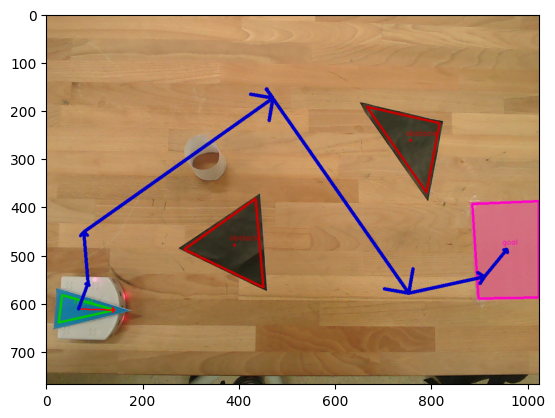

In [3]:
motors(0,0)
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-7)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)

if cv_successful:
    start = np.array([robot[0], robot[1]])
    goal = np.array([goal[0], goal[1]])
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 
        
    metric_path = np.zeros(np.shape(path))

    # invert y axis
    for i in range(len(path)):
        path[i] = invert_coordinates(path[i])
    metric_start = invert_coordinates(start)
    metric_goal = invert_coordinates(goal)

    # change to metric  

    for i in range(len(path)):
        metric_path[i] = pixel_to_metric(path[i])
    metric_start = pixel_to_metric(metric_start)
    metric_goal = pixel_to_metric(metric_goal)
    
    
    print('start =', metric_start, 'goal =', metric_goal, 'angle =', -robot[2])

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
ret, frame = video_capture.read()
# print frame size
print(frame.shape)

print(ret)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cv2.imwrite('frame.jpeg', frame)

### Step 3 : Pathing

In [4]:
cam, kal, pred, video = pathing(video_capture, metric_path, metric_start[0], metric_start[1], -robot[2])
print("finished")
motors(stop, stop)

0.14612 robot_detected: True Distance: [122.]x: [60.11] y: [71.96] theta: [-0.02]
0.14908 robot_detected: True Distance: [98.]x: [61.44] y: [95.94] theta: [-0.02]
0.145 robot_detected: True Distance: [87.]x: [61.54] y: [107.94] theta: [-0.02]
0.14353 robot_detected: True Distance: [79.]x: [62.58] y: [115.12] theta: [-0.02]
0.14501 robot_detected: True Distance: [73.]x: [67.19] y: [120.29] theta: [0.08]
0.139 robot_detected: True Distance: [68.]x: [72.31] y: [124.71] theta: [0.16]
0.15453 robot_detected: True Distance: [64.]x: [78.34] y: [128.89] theta: [0.31]
0.14804 robot_detected: True Distance: [59.]x: [83.79] y: [133.77] theta: [0.42]
0.15501 robot_detected: True Distance: [54.]x: [88.76] y: [138.79] theta: [0.57]
0.142 robot_detected: True Distance: [50.]x: [91.51] y: [143.41] theta: [0.66]
0.14757 robot_detected: True Distance: [46.]x: [95.33] y: [149.15] theta: [0.79]
0.15471 robot_detected: True Distance: [42.]x: [96.72] y: [153.6] theta: [0.9]
0.15364 robot_detected: True Dist

### Step 4 : Plotting

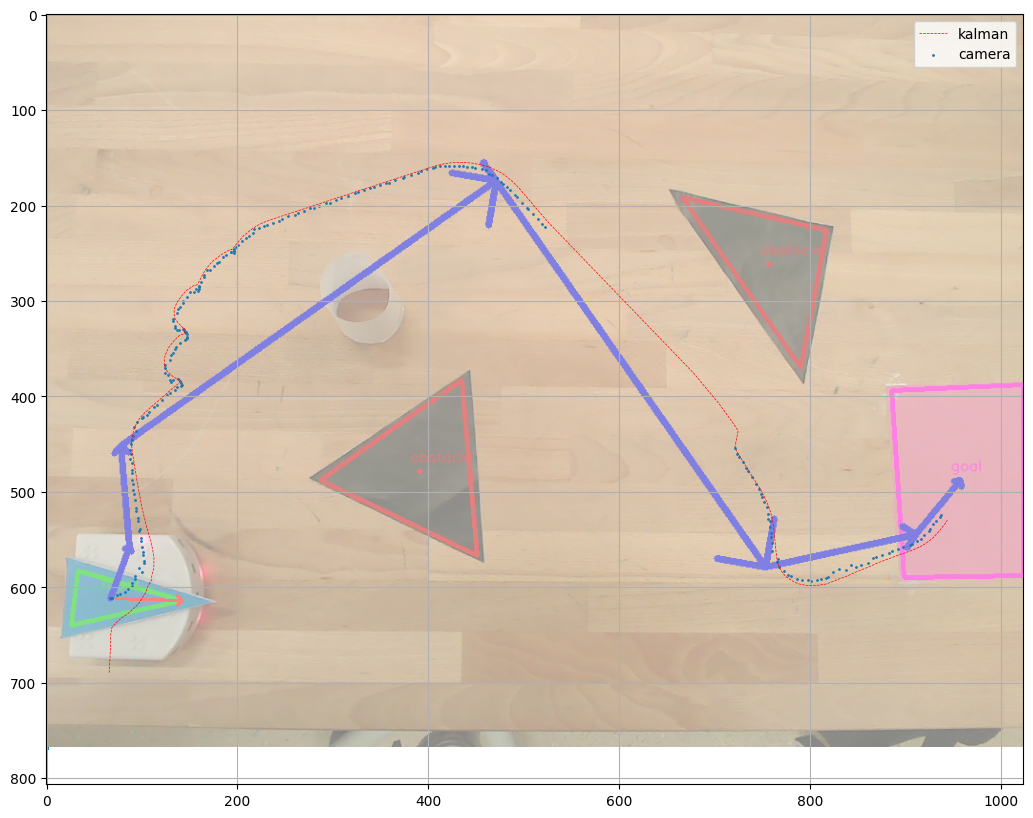

In [5]:
cam_copy = np.array(cam)
kal_copy = np.array(kal)
pred_copy = np.array(pred)
obst_copy  = np.array(obst)
plt.figure(figsize=(15,10))
#plot
pixel_cam = np.zeros(np.shape(cam_copy))
pixel_kal = np.zeros(np.shape(kal_copy))
pixel_pred = np.zeros(np.shape(pred_copy))
# transform to pixel
for i in range(len(cam)):
    pixel_cam[i] = metric_to_pixel(cam_copy[i])
    pixel_kal[i] = metric_to_pixel(kal_copy[i])

implot = plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), origin='upper', alpha=0.5)
plt.plot(pixel_kal[:,0], -pixel_kal[:,1] + CAMERA_HEIGHT, 'r', label='kalman', linestyle='--', linewidth=0.5)
plt.scatter(pixel_cam[:,0], -pixel_cam[:,1]+ CAMERA_HEIGHT, label='camera',s = 1)


plt.legend()
plt.grid()
plt.show()


In [6]:
height, width, layers = len(video[0]), len(video[0][0]), len(video[0][0][0])
size = (width,height)
out = cv2.VideoWriter('project.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(video)):
    out.write(video[i])
    print(i)

out.release()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# 7) Conclusion


This project ended up being quite challenging, not so much for each individual block composing it, but more so due to their integration. Errors could come from any one parameter changed, that impacted everything else, be it the performance or the precision. We did not have enough time to sharpen and improve certain aspects, such as the filter precision, the local navigation reactivity, the computer vision auto-adjustment, among other details. But as a whole, the project works quite well.